In [13]:
cd ~/data/modl_data/pipeline/contrast/prediction/8/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/8


In [14]:
ls

_artifacts/  config.json  cout.txt  info.json  prediction.csv  run.json


In [15]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [16]:
%matplotlib inline

def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [17]:
cd _artifacts

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/8/_artifacts


In [18]:
from modl.fixes import OurModel
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

In [7]:
estimator.named_steps['classifier']

FistaClassifier(C=0.0004761904761904762, alpha=0.0001, callback=None, eta=2.0,
        loss='log', max_iter=200, max_steps=30, multiclass=True,
        penalty='trace', sigma=1e-05, verbose=2)

In [40]:
model = estimator.named_steps['classifier']
coef = model.coef_

In [42]:
res = np.linalg.svd(coef)

In [44]:
res[1]

array([  3.32424923e+01,   2.83673113e+01,   2.34069352e+01,
         2.30672137e+01,   2.14866303e+01,   2.06442428e+01,
         2.04732451e+01,   1.79399134e+01,   1.64178422e+01,
         1.49793198e+01,   1.43099019e+01,   1.33512122e+01,
         1.22020421e+01,   1.18460982e+01,   1.11655915e+01,
         1.10425169e+01,   1.00524227e+01,   9.40690304e+00,
         8.70137838e+00,   8.38983085e+00,   8.07564555e+00,
         7.37529466e+00,   6.55148362e+00,   5.91249800e+00,
         5.64868837e+00,   5.57387673e+00,   5.01227118e+00,
         3.74344727e+00,   3.18631228e+00,   1.47626322e-14])

In [26]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T

print('Sparsity', (coef == 0).sum() / coef.size)

AttributeError: 'FistaClassifier' object has no attribute 'stacked_model_'

In [30]:
prediction

predicted_label  \
fold dataset subject task      contrast             direction                         
test archi   2       emotional expression_control   level1             face_control   
                               expression_intention level1         mecanistic_video   
                               expression_sex       level1         mecanistic_video   
                               face_control         level1             face_control   
                               face_sex             level1             face_control   
                               face_trusty          level1         mecanistic_video   
                     localizer audio                level1                    audio   
                               calculaudio          level1              calculaudio   
                               calculvideo          level1              calculvideo   
                               clicDaudio           level1               clicDaudio   
                               clicDvideo           level1               clicDvideo   
                               clicGaudio           level1               clicGaudio   
                               clicGvideo           level1               clicGvideo   
                               computation          level1              computation   
                               damier_H             level1                 damier_V   
                               damier_V             level1                 damier_V   
                               motor-cognitive      level1          motor-cognitive   
                     parietal  object_grasp         level1             object_grasp   
                               object_orientation   level1               clicDvideo   
                               rotation_hand        level1            rotation_hand   
                               rotation_side        level1            rotation_side   
                               saccade              level1                  saccade   
                     social    false_belief_audio   level1       false_belief_audio   
                               false_belief_video   level1         mecanistic_video   
                               mecanistic_audio     level1         mecanistic_audio   
                               mecanistic_video     level1         mecanistic_video   
                               non_speech           level1               non_speech   
                               speech               level1                   speech   
                               triangle_intention   level1       triangle_intention   
                               triangle_random      level1          triangle_random   
...                                                                             ...   
val  archi   73      emotional expression_control   level1       expression_control   
                               expression_intention level1     expression_intention   
                               expression_sex       level1           expression_sex   
                               face_control         level1       expression_control   
                               face_sex             level1                 face_sex   
                               face_trusty          level1              face_trusty   
                     localizer audio                level1                    audio   
                               calculaudio          level1              computation   
                               calculvideo          level1       false_belief_video   
                               clicDaudio           level1               clicDaudio   
                               clicDvideo           level1               clicDvideo   
                               clicGaudio           level1               clicGaudio   
                               clicGvideo           level1               clicGvideo   
                               computation          level1        

In [31]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [32]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

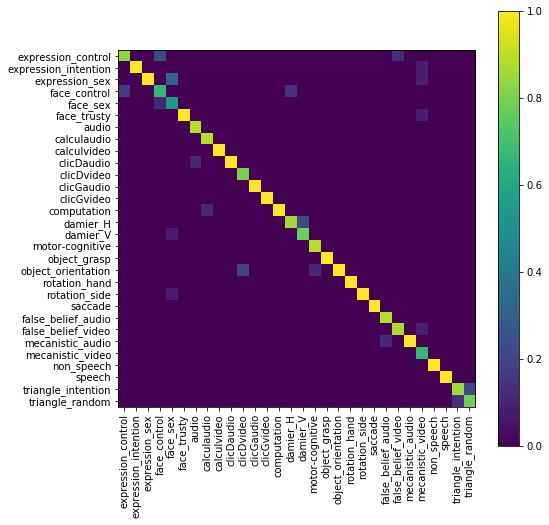

In [35]:
plot_confusion_matrix(test_conf, labels)

In [36]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task       contrast            
archi    emotional  expression_control      0.625
                    expression_intention    0.875
                    expression_sex          0.375
                    face_control            0.750
                    face_sex                0.875
                    face_trusty             0.875
         localizer  audio                   1.000
                    calculaudio             1.000
                    calculvideo             1.000
                    clicDaudio              0.875
                    clicDvideo              1.000
                    clicGaudio              1.000
                    clicGvideo              1.000
                    computation             0.875
                    damier_H                0.750
                    damier_V                0.875
                    motor-cognitive         1.000
         parietal   object_grasp            1.000
                    object_orientation      0.625
         

In [37]:
idx = pd.IndexSlice
prediction.loc[idx['test']]

predicted_label  \
dataset subject task      contrast             direction                         
archi   2       emotional expression_control   level1             face_control   
                          expression_intention level1         mecanistic_video   
                          expression_sex       level1         mecanistic_video   
                          face_control         level1             face_control   
                          face_sex             level1             face_control   
                          face_trusty          level1         mecanistic_video   
                localizer audio                level1                    audio   
                          calculaudio          level1              calculaudio   
                          calculvideo          level1              calculvideo   
                          clicDaudio           level1               clicDaudio   
                          clicDvideo           level1               clicDvideo   
                          clicGaudio           level1               clicGaudio   
                          clicGvideo           level1               clicGvideo   
                          computation          level1              computation   
                          damier_H             level1                 damier_V   
                          damier_V             level1                 damier_V   
                          motor-cognitive      level1          motor-cognitive   
                parietal  object_grasp         level1             object_grasp   
                          object_orientation   level1               clicDvideo   
                          rotation_hand        level1            rotation_hand   
                          rotation_side        level1            rotation_side   
                          saccade              level1                  saccade   
                social    false_belief_audio   level1       false_belief_audio   
                          false_belief_video   level1         mecanistic_video   
                          mecanistic_audio     level1         mecanistic_audio   
                          mecanistic_video     level1         mecanistic_video   
                          non_speech           level1               non_speech   
                          speech               level1                   speech   
                          triangle_intention   level1       triangle_intention   
                          triangle_random      level1          triangle_random   
...                                                                        ...   
        76      emotional expression_control   level1       expression_control   
                          expression_intention level1     expression_intention   
                          expression_sex       level1           expression_sex   
                          face_control         level1       expression_control   
                          face_sex             level1                 face_sex   
                          face_trusty          level1              face_trusty   
                localizer audio                level1                    audio   
                          calculaudio          level1              calculaudio   
                          calculvideo          level1              calculvideo   
                          clicDaudio           level1               clicDaudio   
                          clicDvideo           level1               clicDvideo   
                          clicGaudio           level1               clicGaudio   
                          clicGvideo           level1               clicGvideo   
                          computation          level1              computation   
                          damier_H             level1                 damier_H   
                          damier_V             level1                 damier_V   
                          motor-cognitive    

In [39]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.887500
train  archi      0.968783
val    archi      0.880952
Name: match, dtype: float64

In [ ]:
classifier = estimator.named_steps['classifier']

In [ ]:
histories = classifier.histories_

In [ ]:
history.epoch

In [ ]:
for history, n_samples in zip(histories, classifier.n_samples_):
    plt.plot(np.array(history.epoch) * n_samples, history.history['val_acc'])

In [ ]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [ ]:
np.mean(w0 == 0),np.mean(w1 == 0)

In [ ]:
np.histogram(w1)

In [ ]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)